Assignment 2 For Clustering: Sessa Empirical Estimator


*   Ouano, Luis Andrei E.
*   Detablan, Paul France M.



Instructions
Assignment 2 For Clustering: Sessa Empirical Estimator


1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Sunday, Feb 23, 2022 at 11:59 pm
7. Do this with your thesis partner.
8. You can use any A.I. assistant.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from scipy.stats import ecdf
from datetime import datetime, timedelta

In [7]:
# Parameters
num_patients = 1000  # Total number of patients
observation_period = 720  # 2 years in days
initial_fill_duration = 30  # Initial fill duration in days
refill_durations = [30, 60, 90]  # Possible refill durations

# Function to generate refill history for a single patient
def generate_refill_history(group, patient_id):
    refills = []
    current_date = datetime(2023, 1, 1)  # Start date
    refill_date = current_date
    refill_duration = initial_fill_duration

    medication = "medA" if patient_id < num_patients/2 else "medB"

    # Generate refills based on group
    if group == 1:  # High adherence
        while refill_date < current_date + timedelta(days=observation_period):
            refills.append((patient_id, refill_date, medication, refill_duration))
            refill_date += timedelta(days=int(refill_duration))
            refill_duration = np.random.choice(refill_durations)

    elif group == 2:  # Erratic adherence
        while refill_date < current_date + timedelta(days=observation_period):
            refills.append((patient_id, refill_date, medication, refill_duration))
            refill_date += timedelta(days=int(np.random.choice([15, 30, 45, 60, 90])))  # Convert to int
            refill_duration = np.random.choice(refill_durations)

    elif group == 3:  # Gradual decline
        delay = 0
        while refill_date < current_date + timedelta(days=observation_period):
            refills.append((patient_id, refill_date, medication, refill_duration))
            delay += 10  # Gradually increase delay between refills
            refill_date += timedelta(days=int(refill_duration + delay))  # Convert to int
            refill_duration = np.random.choice(refill_durations)

    elif group == 4:  # Intermittent adherence (alternating periods)
        phase = 0  # 0 = high adherence phase, 1 = low adherence phase
        phase_duration = 90  # Days per phase

        while refill_date < current_date + timedelta(days=observation_period):
            refills.append((patient_id, refill_date, medication, refill_duration))

            # Alternate between good and poor adherence every phase_duration days
            if phase == 0:
                # High adherence: small random variation
                refill_date += timedelta(days=int(refill_duration + np.random.randint(-5, 5)))
            else:
                # Low adherence: larger random delays
                refill_date += timedelta(days=int(refill_duration + np.random.randint(15, 30)))

            # Switch phase every phase_duration days
            if (refill_date - current_date).days % phase_duration == 0:
                phase = 1 - phase  # Toggle between 0 and 1

            refill_duration = np.random.choice(refill_durations)

    elif group == 5:  # Partial drop-off
        drop_point = 360  # Days after which adherence drops
        dropped = False

        while refill_date < current_date + timedelta(days=observation_period):
            refills.append((patient_id, refill_date, medication, refill_duration))

            # Check if we've passed the drop point
            if not dropped and (refill_date - current_date).days > drop_point:
                dropped = True
                base_delay = 30  # Base delay after drop-off

            if dropped:
                # Increasing delays with random variation
                refill_date += timedelta(days=int(refill_duration + base_delay))
                base_delay += 15  # Increase delay each time
            else:
                # Maintain good adherence
                refill_date += timedelta(days=int(refill_duration))

            refill_duration = np.random.choice(refill_durations)

    elif group == 6:  # Non-persistence
        # Initial fill + 1-2 refills only
        refill_count = 0
        max_refills = np.random.randint(1, 3)  # 1 or 2 refills

        while refill_count < max_refills:
            refills.append((patient_id, refill_date, medication, refill_duration))
            refill_date += timedelta(days=int(refill_duration))
            refill_duration = np.random.choice(refill_durations)
            refill_count += 1

    return refills

# Generate data for all patients
data = []
for patient_id in range(num_patients):
    group = np.random.choice([1, 2, 3])  # Add groups 4, 5, 6
    data.extend(generate_refill_history(group, patient_id))

# Convert to DataFrame
df = pd.DataFrame(data, columns=["pnr", "eksd", "ATC", "dur_original"])

# Prepare the tidy DataFrame
tidy = df.copy()
# tidy.columns = ["pnr", "eksd", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'])

In [8]:
def See(arg1, tidy):
    # Get data for the specified medication
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()

    if len(C09CA01) == 0:
        raise ValueError(f"No data found for medication {arg1}")

    # Sort by patient and date
    C09CA01 = C09CA01.sort_values(by=['pnr', 'eksd'])

    # Calculate intervals for each patient
    intervals = []
    patient_data_list = []  # Store patient data for later use

    for patient_id in C09CA01['pnr'].unique():
        patient_data = C09CA01[C09CA01['pnr'] == patient_id]
        if len(patient_data) > 1:
            dates = patient_data['eksd'].values
            patient_intervals = np.diff(dates).astype('timedelta64[D]').astype(int)
            intervals.extend(patient_intervals)
            patient_data_list.append(patient_data)

    if len(intervals) == 0:
        raise ValueError("No intervals could be calculated")

    # Calculate ECDF
    ecdf_x = np.sort(intervals)
    ecdf_y = np.arange(1, len(ecdf_x) + 1) / len(ecdf_x)

    dfper = pd.DataFrame({'x': ecdf_x, 'y': ecdf_y})

    # Filter points
    dfper = dfper[dfper['y'] <= 0.8]

    if len(dfper) == 0:
        raise ValueError("No data points remain after filtering for 80% ECDF")

    # Calculate silhouette scores
    a = scale(dfper['x'].values.reshape(-1, 1))

    silhouette_scores = []
    K = range(2, 8)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(a)
        silhouette_avg = silhouette_score(a, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Return both silhouette scores and the processed DataFrame
    final_df = pd.concat(patient_data_list) if patient_data_list else pd.DataFrame()
    return {'scores': silhouette_scores, 'data': final_df}

In [9]:
def see_assumption(result):
    if isinstance(result, dict):
        arg1 = result['data']
    else:
        raise TypeError("Expected a dictionary with 'data' key from See function")

    arg1 = arg1.sort_values(by=['pnr', 'eksd']).groupby('pnr').apply(
        lambda x: x.assign(prev_eksd=x['eksd'].shift(1))).reset_index(drop=True)

    Drug_see2 = arg1.groupby('pnr').apply(
        lambda x: x.assign(p_number=np.arange(len(x)) + 1)).reset_index(drop=True)
    Drug_see2 = Drug_see2[Drug_see2['p_number'] >= 2]
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days
    Drug_see2['p_number'] = Drug_see2['p_number'].astype('category')

    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().reset_index()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.axhline(y=medians_of_medians['Duration'].median(), color='r', linestyle='--')
    plt.title('Duration by Prescription Number')
    plt.show()

    return Drug_see2  # Optional: return processed data for further analysis

<ipython-input-9-afd891b3f82e>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  arg1 = arg1.sort_values(by=['pnr', 'eksd']).groupby('pnr').apply(
<ipython-input-9-afd891b3f82e>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see2 = arg1.groupby('pnr').apply(


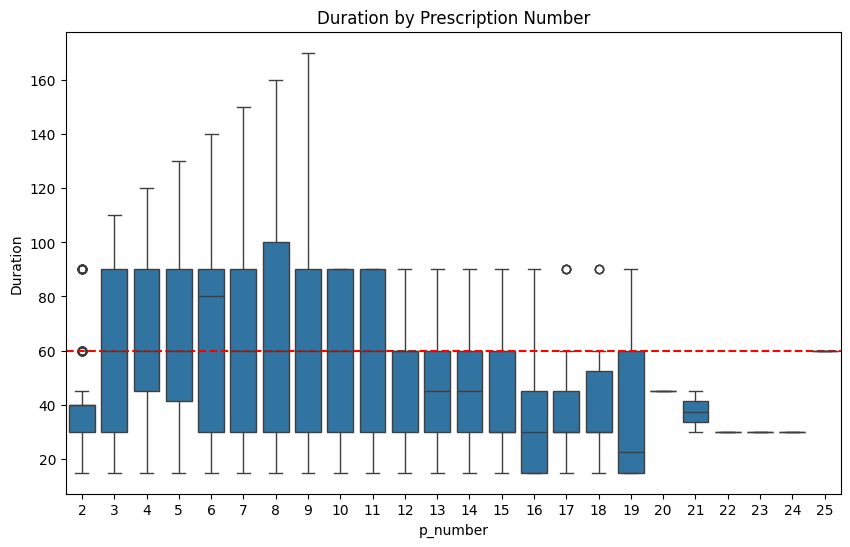

<ipython-input-9-afd891b3f82e>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  arg1 = arg1.sort_values(by=['pnr', 'eksd']).groupby('pnr').apply(
<ipython-input-9-afd891b3f82e>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see2 = arg1.groupby('pnr').apply(


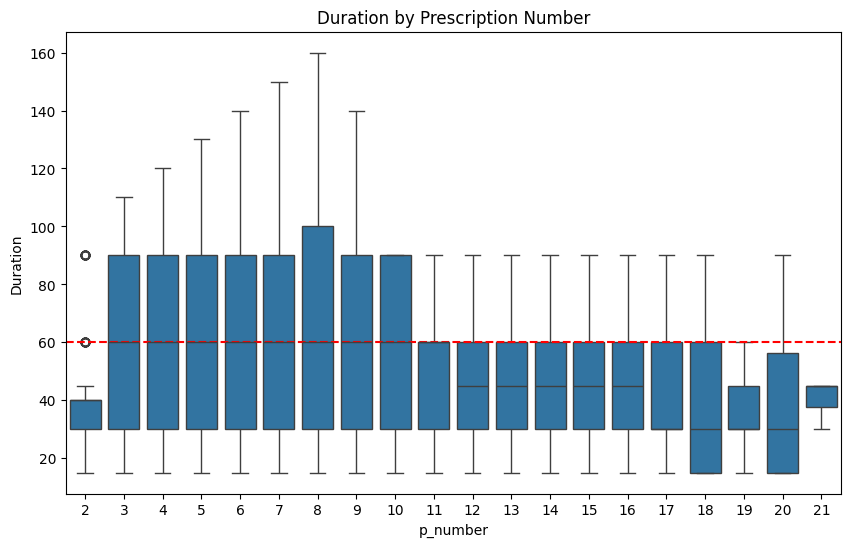

Silhouette scores for medA: [0.617109066606309, 0.7454400381023779, 0.8072490062083328, 0.9351928726825836, 0.9518311599948774, 0.9639400884811622]
Silhouette scores for medB: [0.6139664663430549, 0.7515132014359703, 0.8105644414833402, 0.940139303428987, 0.9552533840683733, 0.9668553323148771]


In [10]:
# add labels later for which graph is medA and medB
medA_result = See("medA", tidy)
medB_result = See("medB", tidy)

# Analyze the results
see_assumption(medA_result)
see_assumption(medB_result)

# To access silhouette scores
print("Silhouette scores for medA:", medA_result['scores'])
print("Silhouette scores for medB:", medB_result['scores'])